In [1]:
%reload_ext autoreload
%autoreload 2

import dill as pickle
import pandas as pd
import pycmtensor as cmt
from pycmtensor.models import MNLogit
from pycmtensor.optimizers import Adam
from pycmtensor.expressions import Beta, Weights
from pycmtensor.results import Results, Predict

cmt.logger.set_level(cmt.logger.WARNING)


In [2]:

swissmetro = pd.read_csv("data/swissmetro.dat", sep="\t")
db = cmt.Database(name="swissmetro", pandasDatabase=swissmetro, choiceVar="CHOICE")
globals().update(db.variables)
# Removing some observations
exclude = ((PURPOSE != 1) * (PURPOSE != 3) + (CHOICE == 0)) > 0
db.remove(exclude)

# additional steps to format database
db.data["CHOICE"] -= 1 # set the first choice to 0
db.choices = sorted(db.data["CHOICE"].unique()) # save original choices
db.autoscale(variables=['TRAIN_CO', 'TRAIN_TT', 'CAR_CO', 'CAR_TT', 
    'SM_CO', 'SM_TT'], default=100., verbose=False)

# declare model params here
b_cost = Beta("b_cost", 0.0, None, None, 0)
b_time = Beta("b_time", 0.0, None, None, 0)
b_dist = Beta("b_dist", 0.0, None, None, 0)
b_school = Beta("b_school", 0.0, None, None, 0)
asc_train = Beta("asc_train", 0.0, None, None, 0)
asc_car = Beta("asc_car", 0.0, None, None, 0)
asc_sm = Beta("asc_sm", 0.0, None, None, 1)

U_1 = b_cost * db["TRAIN_CO"] + b_time * db["TRAIN_TT"] + asc_train
U_2 = b_cost * db["SM_CO"] + b_time * db["SM_TT"] + asc_sm
U_3 = b_cost * db["CAR_CO"] + b_time * db["CAR_TT"] + asc_car

# specify the utility function and the availability conditions
U = [U_1, U_2, U_3]
AV = [db["TRAIN_AV"], db["SM_AV"], db["CAR_AV"]]

mymodel = MNLogit(u=U, av=AV, database=db, name="mymodel")
mymodel.add_params(locals())

# set training configuration
mymodel.config["patience"] = 20000
mymodel.config["cyclic_lr_step_size"] = 8
mymodel.config["base_lr"] = 0.0012
mymodel.config["max_lr"] = 0.002
mymodel.config["cyclic_lr_mode"] = "triangular2"

# train function
model = cmt.train(mymodel, database=db, optimizer=Adam, batch_size=128, max_epoch=999, notebook=True)

with open("myModel.pkl", "rb") as f:
    model = pickle.load(f)

result = Results(model, db, show_weights=True)
result.print_beta_statistics()
result.print_correlation_matrix()

[2022-03-09 16:18:37] WARNING: Unused Betas from computational graph: b_dist b_school removed. To explicity keep params in model, set param status=1.


dataset: swissmetro (n=6768)
batch size: 128
iterations per epoch: 52


Loglikelihood:  -6964.663  Score: 0.134

Epoch    0/51948:   0%|          | 0.00/51.9k [00:00<?, ?it/s]

[2022-03-09 16:19:10] WARNING: Maximum patience reached. Early stopping...


Optimization complete with accuracy of 62.618%. Max loglikelihood reached @ epoch 195.

Results for model: mymodel
Build time: 00:00:08
Estimation time: 00:00:25
Estimation rate: 15.593 epochs/s
Seed value: 999
Number of Beta parameters: 4
Sample size: 6768
Excluded data: 3960
Init loglikelihood: -6964.663
Final loglikelihood: -5590.672
Final loglikelihood reached at: epoch 195
Likelihood ratio test: 2747.982
Accuracy: 62.618%
Rho square: 0.197
Rho bar square: 0.197
Akaike Information Criterion: 11189.34
Bayesian Information Criterion: 11216.62
Final gradient norm: 0.105

Statistical Analysis:
              Value   Std err     t-test   p-value Rob. Std err Rob. t-test Rob. p-value
asc_car    0.111659  0.042073   2.653951  0.007956     0.038273    2.917394      0.00353
asc_train -0.624215  0.054714 -11.408683       0.0     0.014498  -43.055581          0.0
b_cost     0.002806   0.00255   1.100713  0.271021     0.003422    0.820145     0.412134
b_time    -1.161239  0.054092 -21.467857   

<Figure size 432x288 with 0 Axes>

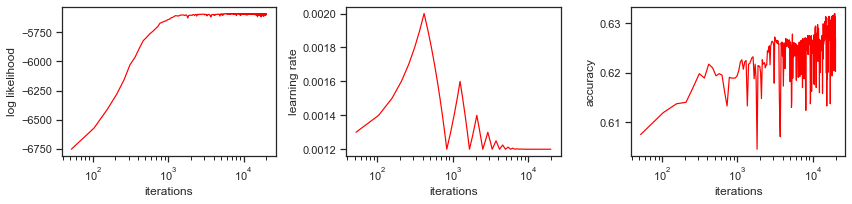

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 1.2})
sns.despine()
log = model.tracker.get_data()
fig, axs = plt.subplots(1, 3, figsize=(12, 3), squeeze=False)
g1 = sns.lineplot(ax=axs[0, 0], data=log, x=log.index, y="full_ll", color='red') 
g2 = sns.lineplot(ax=axs[0, 1], data=log, x=log.index, y="lr", color='red')
g3 = sns.lineplot(ax=axs[0, 2],data=log, x=log.index, y="score", color='red') # y = score or full_ll or lr
g1.set(xscale="log", xlabel="iterations", ylabel="log likelihood")
g2.set(xscale="log", xlabel="iterations", ylabel="learning rate")
g3.set(xscale="log", xlabel="iterations", ylabel="accuracy")
plt.tight_layout()
plt.show()

In [4]:
from aesara.tensor.random.utils import RandomStream

class ResLogitLayer:
    def __init__(self, input, w_in, w_out, activation_in=None, activation_out=None):
        assert w_in.shape[1].eval() == w_out.shape[0].eval()
        if isinstance(input, (list, tuple)):
            assert len(input) == w_in.shape[0].eval(), f"index.0 of w_in must be of the same length as input"
            input = aet.stacklists(input).flatten(2)

        assert isinstance(w_in, (Weights)), "w_in must be of type Weights"
        assert isinstance(w_out, (Weights)), "w_out must be of type Weights"
        self.w_in = w_in()
        self.w_out = w_out()
        if activation_in == None:
            activation_in = aet.sigmoid
        if activation_out == None:
            activation_out = aet.sigmoid
            
        h = activation_in(aet.dot(input.T, self.w_in))
        output = activation_out(aet.dot(h, self.w_out)).T
        self.input = input
        self.weights = [self.w_in, self.w_out]
        self.output = output + input

    
    def __repr__(self):
        return f"ResLogitLayer([{self.w_in.shape.eval()}, {self.w_out.shape.eval()}])"

The output file is available at viz/print.png


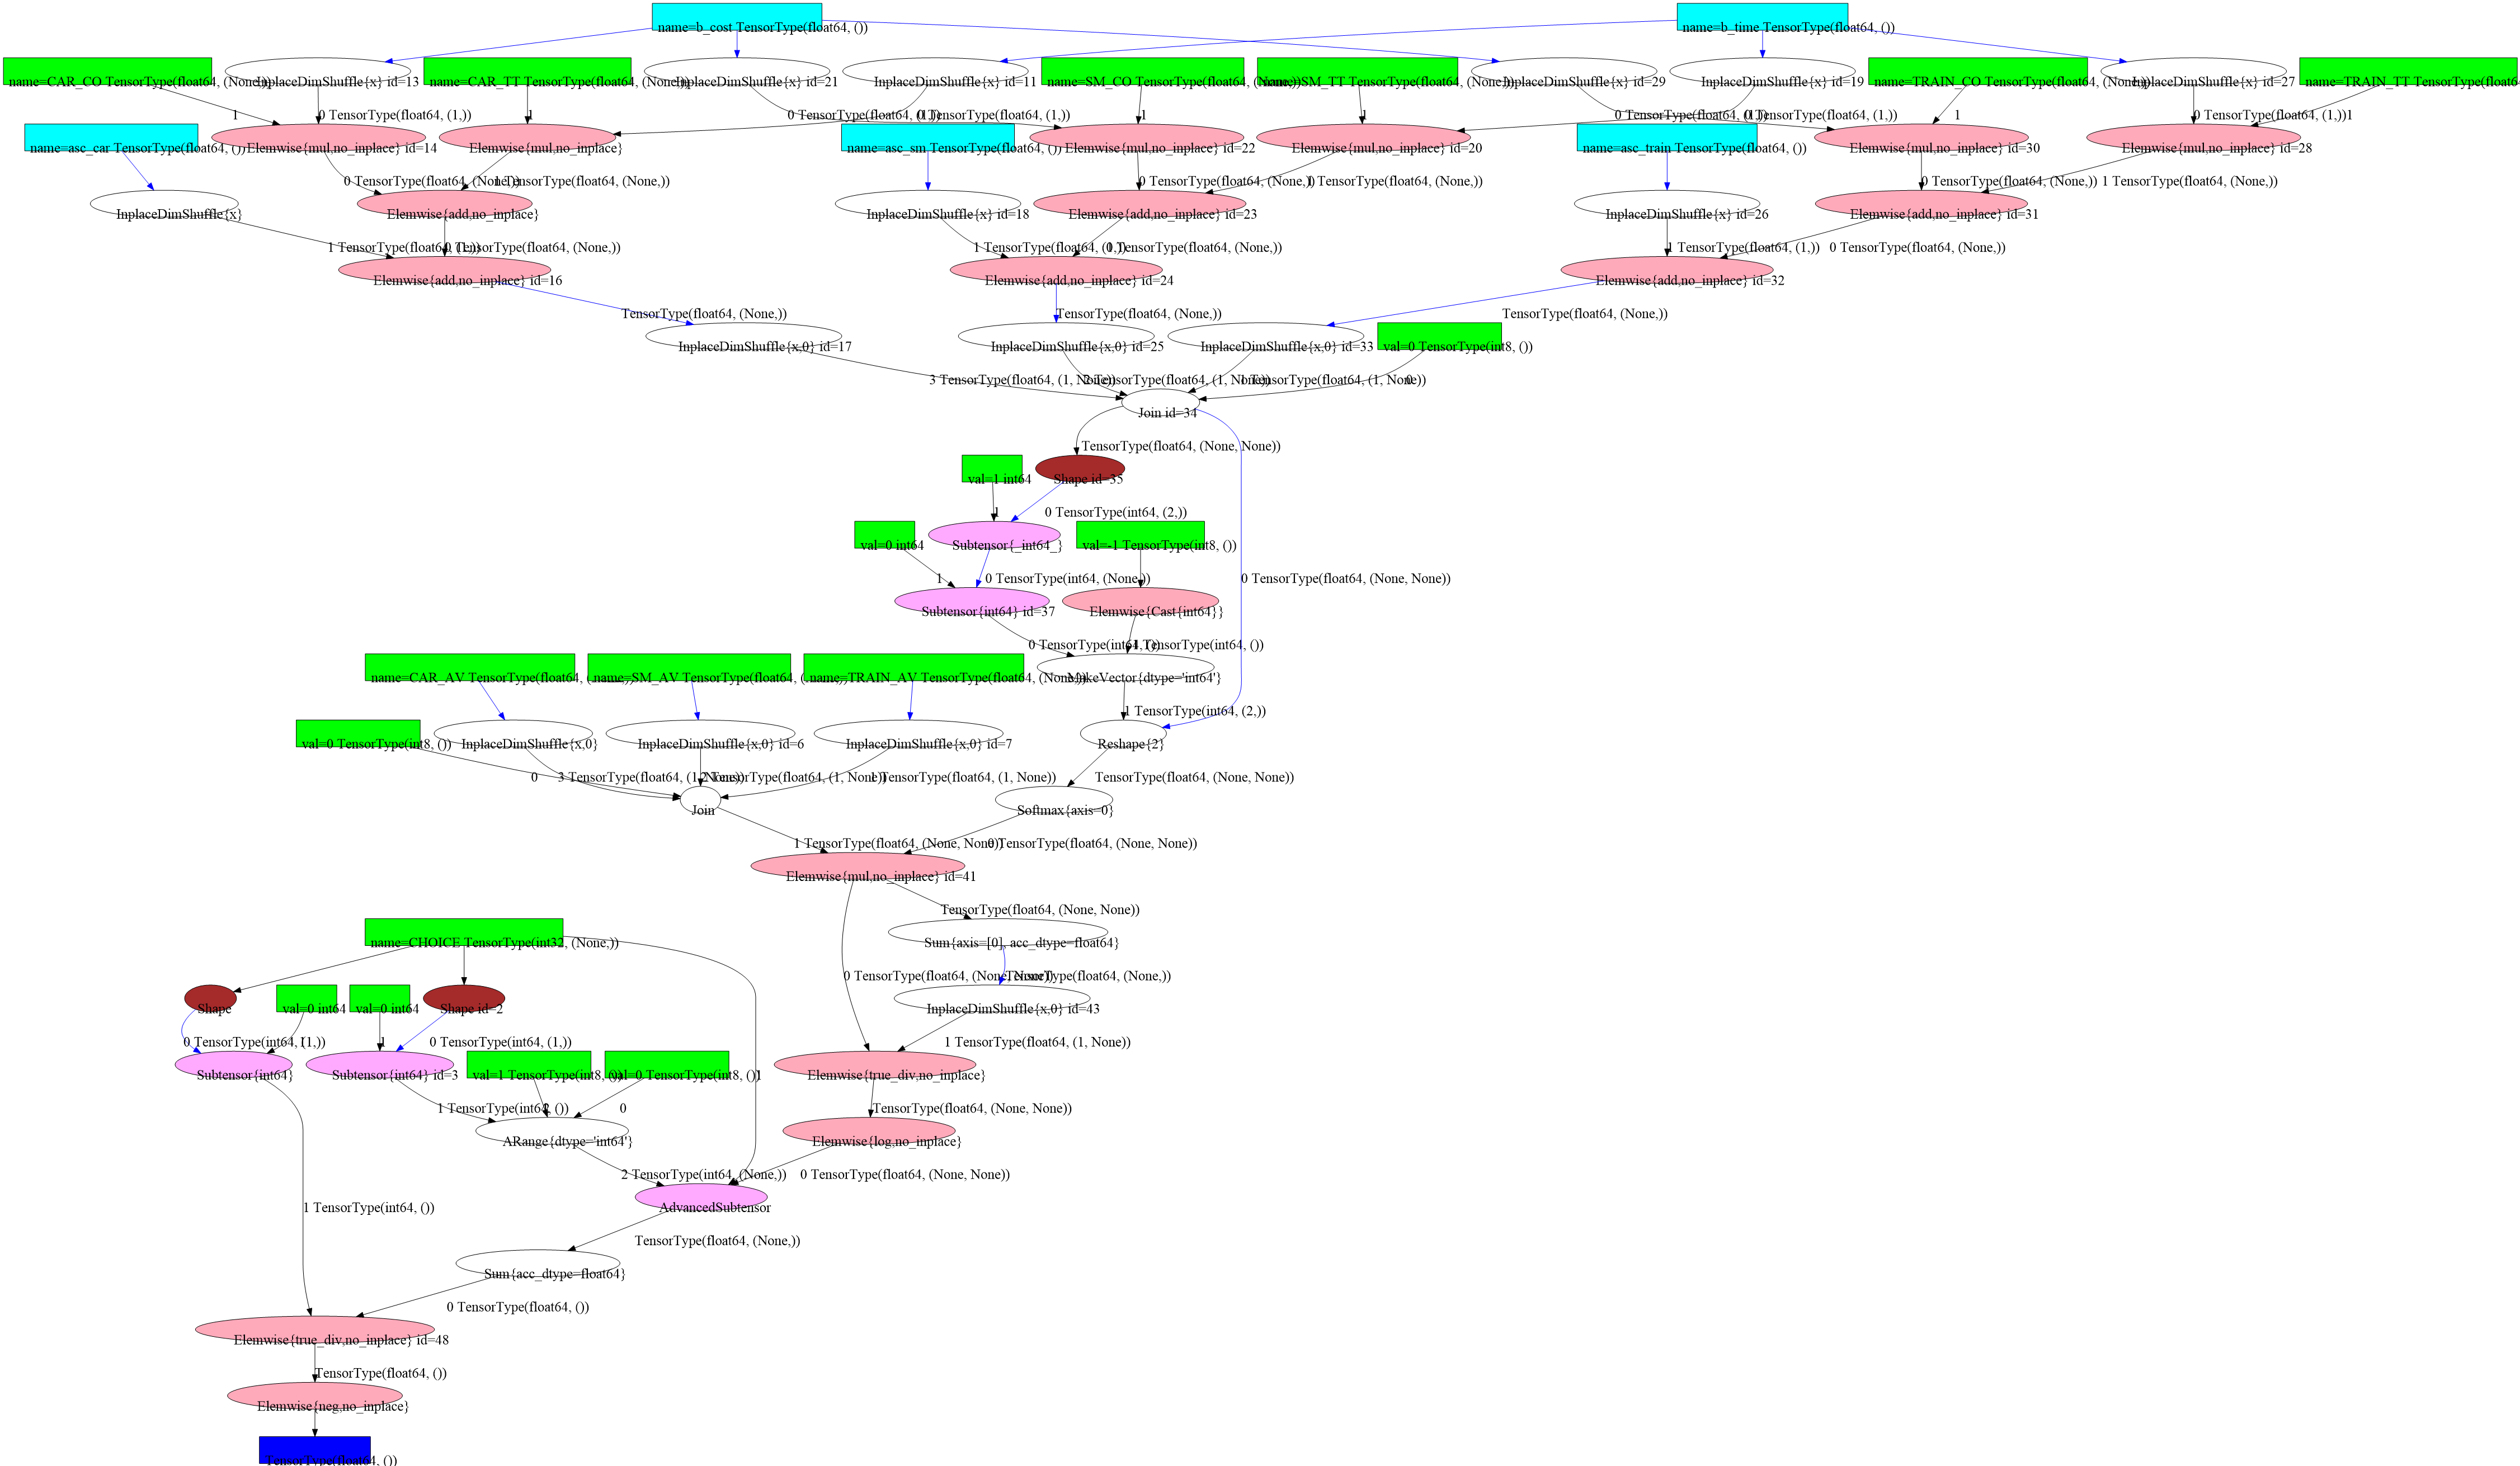

In [5]:
import aesara.d3viz as d3v
from aesara import printing
d3v.d3viz(model.loglikelihood, 'viz/MNLogit.html')

printing.pydotprint(mymodel.cost, "viz/print.png")
from IPython.display import Image
Image("viz/print.png", width="80%")

In [6]:
from pycmtensor.results import Predict
from pycmtensor.pycmtensor import PyCMTensorModel
import dill as pickle

class MNLmodel(PyCMTensorModel):
    def __init__(self, db):
        super().__init__(db)

with open("myModel.pkl", "rb") as f:
    model = pickle.load(f)

Predict(model, db).choices()

,CHOICE
0,1
1,1
2,1
3,2
4,1
...,...
6763,1
6764,1
6765,1
6766,1
